In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import colorcet as cc
import matplotlib.cm as cm
import os
plt.style.use("/n/home11/bjia/bio_publications.mplstyle")
import sys
sys.path.append("../SpikeCounter")
sys.path.append("../ephysSimsPython")
from spikecounter import utils
import pandas as pd
import seaborn as sns
import pickle
import shutil
from scipy import stats
import importlib

In [2]:
def reload_libraries():
    importlib.reload(utils)

In [17]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20221110_pde_gradI_vary/"
figdir = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures"

In [4]:
def process_stats(df, subfolder):
    df["mean_origin_pos"] = np.nan
    df["std_origin_pos"] = np.nan

    df["frac_25"] = np.nan
    df["origin_entropy"] = np.nan
    df["mean_area"] = np.nan
    df["frac_full_area"] = np.nan
    df["mean_isi"] = np.nan
    df["std_isi"] = np.nan
    df["cv_isi"] = np.nan
    df["phase_drift_rate"] = np.nan
    df["phase_variance"] = np.nan
    df["crossings_per_cycle"] = np.nan
    df["n_waves"] = np.nan
    for idx in range(df.shape[0]):
        row = df.iloc[idx]
        measurements = np.load(os.path.join(rootdir, subfolder, row["sim_id"], "stats.npz"))
        wave_origins = measurements["all_wave_origins"]
        areas = measurements["all_areas"]
        df["mean_origin_pos"].iat[idx] = np.nanmean(wave_origins)
        df["std_origin_pos"].iat[idx] = np.nanstd(wave_origins)
        df["frac_25"].iat[idx] = np.nansum(wave_origins==24)/len(wave_origins)
        df["origin_entropy"].iat[idx] = stats.entropy(np.bincount(wave_origins[np.isfinite(wave_origins)].astype(int)),\
                                                      base=2)
        df["mean_area"].iat[idx] = np.nanmean(areas)
        df["frac_full_area"].iat[idx] = np.nansum(areas==25)/len(areas)
        df["mean_isi"].iat[idx] = np.nanmean(measurements["mean_isi"])
        df["std_isi"].iat[idx] = np.nanmean(measurements["std_isi"])
        df["cv_isi"].iat[idx] = np.nanmean(measurements["std_isi"]/measurements["mean_isi"])
        df["n_waves"].iat[idx] = len(wave_origins)
        
        phase_diff = np.squeeze(measurements["phase_diff"])
        drift_rates = []
        phase_variance = []
        
        dt = 0.1
        x = np.arange(phase_diff.shape[0])*dt
        
        mod_zero_centered = np.mod(phase_diff[x>100], np.pi*2)
        mod_zero_centered[mod_zero_centered > np.pi] = mod_zero_centered[mod_zero_centered > np.pi] - np.pi*2
        mean_zero_centered = np.mean(mod_zero_centered, axis=0)
        mod_mean_centered = np.mod(mod_zero_centered - mean_zero_centered, np.pi*2)
        mod_mean_centered[mod_mean_centered > np.pi] = mod_mean_centered[mod_mean_centered > np.pi] - np.pi*2
        phase_variance.append(np.nanvar(mod_mean_centered, axis=0))
        

        for i in range(phase_diff.shape[1]):
            fit = stats.linregress(x, phase_diff[:,i])
            drift_rates.append(fit.slope)

        all_wave_timings = measurements["all_wave_timings"]
        if row["duration"] > 10000:
            all_wave_timings = all_wave_timings-40000
        all_wave_timings = all_wave_timings[all_wave_timings>100]
        if len(all_wave_timings) >= 3:

            wave_timing_indices = np.round(all_wave_timings*10).astype(int)
            per_wave_phase_diff = []
            kept_indices = [wave_timing_indices[0]]
            for i in range(1, len(wave_timing_indices)):
            #     windowed_diffs = np.mod(phase_diff[wave_timing_indices[i-1]:wave_timing_indices[i]], np.pi*2)
            #     windowed_diffs[windowed_diffs >= np.pi]
                windowed_diffs = phase_diff[kept_indices[-1]:wave_timing_indices[i]]

                if windowed_diffs.shape[0] > 10:
                    kept_indices.append(wave_timing_indices[i])
                    avg_phase_diff = np.mod(np.mean(windowed_diffs, axis=0), np.pi*2)
                    per_wave_phase_diff.append(avg_phase_diff)
            if len(per_wave_phase_diff) > 1:
                per_wave_phase_diff = np.array(per_wave_phase_diff)

                crossings = (np.diff(np.sign(np.diff(per_wave_phase_diff, axis=1)), axis=0)) !=0

                df["phase_drift_rate"].iat[idx] = np.nanmean(np.abs(drift_rates))
                df["phase_variance"].iat[idx] = np.nanmean(phase_variance)
                df["crossings_per_cycle"].iat[idx] = np.nansum(crossings)/len(kept_indices)

        
        
    df["freq"] = 1/df["mean_isi"]
    return df

In [24]:

measurements = np.load(os.path.join(rootdir, "snic", "snic_20221025_140418_77d862bb-1", "stats.npz"))
wave_origins = measurements["all_wave_origins"].astype(int)

In [25]:
np.bincount(wave_origins)

array([495, 456, 447, 438, 443, 459, 464, 470, 469, 462, 454, 460, 447,
       442, 445, 452, 455, 446, 448, 452, 455, 445, 437, 473, 511])

In [5]:
dfs = {}

In [6]:
def load_data(rootdir, subfolder):
    hashtable = set()
    data = []
    bif_dir = os.path.join(rootdir, subfolder)
    for sim in os.listdir(bif_dir):
#         print(sim)
        sim_dir = os.path.join(bif_dir, sim)
        if os.path.isdir(sim_dir):
            try:
                with open(os.path.join(sim_dir, "params.pickle"), "rb") as pckl:
                    
                    params = pickle.load(pckl)
                    measurements = np.load(os.path.join(sim_dir, "stats.npz"))
                    if np.any(np.isfinite(measurements["mean_isi"])):
                        entry = (params["bif"], float(utils.round_rel_deviation(params["D"])),\
                                 float(utils.round_rel_deviation(params["sigma"])),\
                                 float(utils.round_rel_deviation(params["I_mean"])),\
                                 float(utils.round_rel_deviation(params["I_std"])), \
                                 float(utils.round_rel_deviation(params["I_height"])),\
                                     params["I_intercept"], params["n_y"], params["duration"])
                        h = hash(str(entry))
                        if h not in hashtable:
                            data.append(entry + (sim,))
                            hashtable.add(h)
#                     else:
#                         shutil.rmtree(sim_dir)

            except Exception as e:
#                 raise(e)
                print(e)
#                 shutil.rmtree(sim_dir)
                continue
    df = pd.DataFrame(data, columns=["bifurcation", "D", "sigma", "I_mean",\
            "I_std", "I_height", "I_intercept", "n_cells", "duration", "sim_id"])
    df = df.set_index("bifurcation")
    return df

In [30]:
subfolders = ["snic", "supercritical_hopf"]
bifs = ["snic", "supercritical_hopf"]

In [32]:
for i in range(len(subfolders)):
    dfs[bifs[i]] = process_stats(load_data(rootdir,subfolders[i]).sort_values(["D", "sigma", "I_height"]), subfolders[i])
    dfs[bifs[i]].reset_index().to_csv(os.path.join(rootdir, subfolders[i], "all_simulation_stats.csv"), index=False)

In [ ]:
subfolder = "snic"
dfs[subfolder] = process_stats(load_data(subfolder).sort_values(["D", "sigma", "I_height"]), subfolder)
dfs[subfolder].reset_index().to_csv(os.path.join(rootdir, subfolder, "all_simulation_stats.csv"), index=False)

In [159]:
subfolder = "snic"
remove_mask = dfs[subfolder]["I_mean"] > 10
for sim_id in dfs[subfolder][remove_mask]["sim_id"]:
    sim_dir = os.path.join(rootdir, subfolder, sim_id)
    shutil.rmtree(sim_dir)

In [12]:
with open("/n/holyscratch01/cohen_lab/bjia/20221110_pde_gradI_vary/supercritical_hopf/supercritical_hopf_20221110_184626_c98f9638-a/params.pickle", "rb") as f:
    params = pickle.load(f)

In [14]:
stattest = np.load("/n/holyscratch01/cohen_lab/bjia/20221110_pde_gradI_vary/supercritical_hopf/supercritical_hopf_20221110_184626_c98f9638-a/stats.npz")

In [18]:
list(stattest.keys())

['all_areas',
 'mean_isi',
 'std_isi',
 'first_spike_times',
 'all_wave_origins',
 'all_wave_timings',
 'phase_diff']

In [19]:
stattest['all_areas']

array([], dtype=float64)

In [7]:
def plot_heatmap(df, column, ax, piv_index="D", piv_column="sigma", norm="lin", cax="auto", **cbar_params):
    pv = pd.pivot_table(df, index=[piv_index], columns=[piv_column], values=column)
    Z = pv.to_numpy()
    if norm == "log":
        norm = mpl.colors.LogNorm(vmin=np.nanmin(Z),vmax=np.nanmax(Z))
    elif norm == "lin":
        norm = mpl.colors.Normalize(vmin=np.nanmin(Z),vmax=np.nanmax(Z))
    elif norm is None:
        norm = mpl.colors.Normalize(vmin=np.nanmin(Z),vmax=np.nanmax(Z))
    im = ax.pcolormesh(pv.columns, pv.index, Z,\
                norm=norm)
    ax.set_xscale("log")
    ax.set_yscale("log")
#     ax.set_xlabel(r"$\sigma$")
#     ax.set_ylabel(r"$D$")
    cbar = None
    if cax =="auto":
        cbar = plt.colorbar(im, ax=ax, **cbar_params)
    elif cax is not None:
        cbar = plt.colorbar(im, cax=cax, **cbar_params)
    return ax, im, cbar

Test whether the phase spike detection version works as well

In [18]:
subfolders = ["snic", "supercritical_hopf"]
bifs = ["snic", "supercritical_hopf"]
dfs = {}
for i in range(len(subfolders)):
    dfs[bifs[i]] = pd.read_csv(os.path.join(rootdir, subfolders[i], "all_simulation_stats.csv"))

In [15]:
dfs_single = pd.concat(dfs.values(), axis=0).set_index("bifurcation")
# dfs_single.to_csv(os.path.join(figdir, "Figures", "Data", "pde_sims_gradI_sweep.csv"))

In [16]:
dfs_single.loc["snic"]["sigma"].unique()

array([0.03, 0.3 , 3.  ])

In [10]:
dfs_single["sigma"]

0     0.03
1     0.03
2     0.03
3     0.03
4     0.03
      ... 
69    0.03
70    0.03
71    0.03
72    0.03
73    0.03
Name: sigma, Length: 1153, dtype: float64

In [37]:
dfs_single = dfs_single.set_index(["bifurcation","sigma"])

In [14]:
dfs_single.loc["supercritical_hopf"].index.unique("I_std")

Float64Index([0.0], dtype='float64', name='I_std')

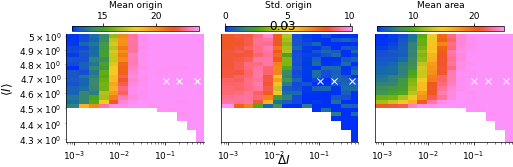

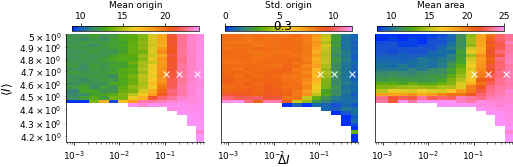

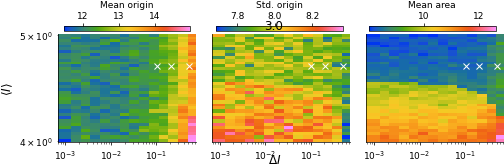

In [47]:
for sigma in dfs_single.loc["snic"].index.unique():
    fig1, axes = plt.subplots(1,3,figsize=(8,2), gridspec_kw={"wspace":0.12})
    cax1 = plt.axes([0.135, 0.9, 0.22, 0.03])
    cax2 = plt.axes([0.40, 0.9, 0.22, 0.03])
    cax3 = plt.axes([0.665, 0.9, 0.22, 0.03])
    ax, im, cbar1 = plot_heatmap(dfs_single.loc["snic"].loc[sigma], "mean_origin_pos",\
                                axes[0], piv_index="I_mean", piv_column="I_height", cax=cax1, orientation="horizontal")
    ax, im, cbar2 = plot_heatmap(dfs_single.loc["snic"].loc[sigma], "std_origin_pos",\
                                axes[1], piv_index="I_mean", piv_column="I_height", cax=cax2, orientation="horizontal")
    ax, im, cbar3 = plot_heatmap(dfs_single.loc["snic"].loc[sigma], "mean_area",\
                                axes[2], piv_index="I_mean", piv_column="I_height", cax=cax3, orientation="horizontal")
    cax1.xaxis.tick_top()

    cax2.xaxis.tick_top()

    cax3.xaxis.tick_top()
    cax1.set_xlabel("Mean origin")
    cax2.set_xlabel("Std. origin")
    cax3.set_xlabel("Mean area")

    cax1.xaxis.set_label_position("top")
    cax2.xaxis.set_label_position("top")
    cax3.xaxis.set_label_position("top")
    axes[0].plot([0.103, 0.206, 0.514], [4.68,4.68,4.68], "wx")
    axes[1].plot([0.103, 0.206, 0.514], [4.68,4.68,4.68], "wx")
    axes[2].plot([0.103, 0.206, 0.514], [4.68,4.68,4.68], "wx")



    axes[1].yaxis.set_visible(False)
    axes[2].yaxis.set_visible(False)
    axes[0].set_ylabel( r"$\langle I \rangle$", fontsize=12)
    fig1.text(0.49, -0.02,r"$\Delta I$", fontsize=12)
    fig1.suptitle(sigma)

# xline = np.logspace(-3, 0)
# yline = 0.5*xline
# axes[0].plot(xline,yline, "k",linewidth=1.5)
# axes[1].plot(xline,yline, "k",linewidth=1.5)
# axes[2].plot(xline,yline, "k",linewidth=1.5)

# axes[0].set_xlim(10**(-3), 0.75)
# axes[1].set_xlim(10**(-3), 0.75)
# axes[2].set_xlim(10**(-3), 0.75)
# axes[0].set_ylim(10**(-3), 1)
# axes[1].set_ylim(10**(-3), 1)
# axes[2].set_ylim(10**(-3), 1)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "I_height_I_mean.tif"), dpi=600)

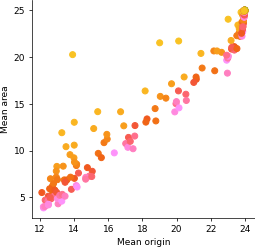

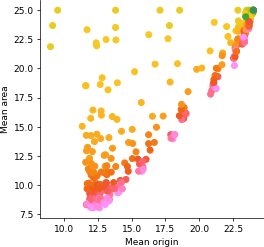

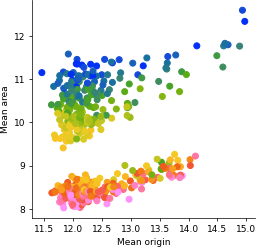

In [52]:
c = "I_mean"
I_slope = np.sort(dfs_single.loc["snic"][c].unique())
cmap = cm.ScalarMappable(norm=colors.LogNorm(vmin=I_slope[0], vmax=I_slope[-1]), cmap=cm_string)
for sigma in dfs_single.loc["snic"].index.unique():
    fig1, ax1 = plt.subplots(figsize=(4,4))
    dat = dfs_single.loc["snic"].loc[sigma]
    ax1.scatter(dat["mean_origin_pos"], dat["mean_area"], c=cmap.to_rgba(dat[c]))
    ax1.set_xlabel("Mean origin")
    ax1.set_ylabel("Mean area")

# xline = np.logspace(-3, 0)
# yline = 0.5*xline
# axes[0].plot(xline,yline, "k",linewidth=1.5)
# axes[1].plot(xline,yline, "k",linewidth=1.5)
# axes[2].plot(xline,yline, "k",linewidth=1.5)

# axes[0].set_xlim(10**(-3), 0.75)
# axes[1].set_xlim(10**(-3), 0.75)
# axes[2].set_xlim(10**(-3), 0.75)
# axes[0].set_ylim(10**(-3), 1)
# axes[1].set_ylim(10**(-3), 1)
# axes[2].set_ylim(10**(-3), 1)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "I_height_I_mean.tif"), dpi=600)

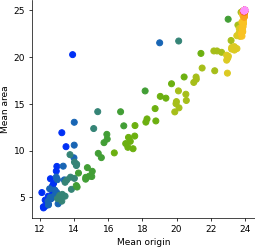

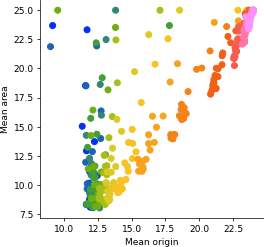

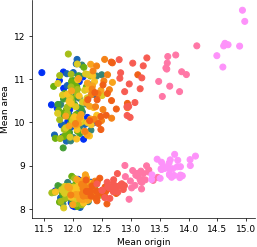

In [51]:
c = "I_height"
I_slope = np.sort(dfs_single.loc["snic"][c].unique())
cmap = cm.ScalarMappable(norm=colors.LogNorm(vmin=I_slope[0], vmax=I_slope[-1]), cmap=cm_string)
for sigma in dfs_single.loc["snic"].index.unique():
    fig1, ax1 = plt.subplots(figsize=(4,4))
    dat = dfs_single.loc["snic"].loc[sigma]
    ax1.scatter(dat["mean_origin_pos"], dat["mean_area"], c=cmap.to_rgba(dat[c]))
    ax1.set_xlabel("Mean origin")
    ax1.set_ylabel("Mean area")

# xline = np.logspace(-3, 0)
# yline = 0.5*xline
# axes[0].plot(xline,yline, "k",linewidth=1.5)
# axes[1].plot(xline,yline, "k",linewidth=1.5)
# axes[2].plot(xline,yline, "k",linewidth=1.5)

# axes[0].set_xlim(10**(-3), 0.75)
# axes[1].set_xlim(10**(-3), 0.75)
# axes[2].set_xlim(10**(-3), 0.75)
# axes[0].set_ylim(10**(-3), 1)
# axes[1].set_ylim(10**(-3), 1)
# axes[2].set_ylim(10**(-3), 1)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "I_height_I_mean.tif"), dpi=600)

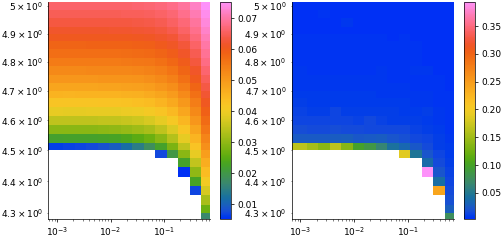

In [19]:
fig1, axes = plt.subplots(1,2, figsize=(8,4))
ax, im, cbar = plot_heatmap(dfs_single.loc[bif].loc[0], "freq", axes[0],\
                    piv_index="I_mean", piv_column="I_height")
ax, im, cbar = plot_heatmap(dfs_single.loc[bif].loc[0], "cv_isi", axes[1],\
                    piv_index="I_mean", piv_column="I_height")

In [38]:
dfs_single.loc["snic", 0.3][["I_mean","cv_isi", "n_waves"]]

I_mean    cv_isi  n_waves
bifurcation sigma                           
snic        0.3      4.94  0.033755   1868.0
            0.3      4.60  0.087205    748.0
            0.3      4.51  0.195598    313.0
            0.3      4.97  0.032840   2040.0
            0.3      4.77  0.048382   1412.0
...                   ...       ...      ...
            0.3      4.77  0.032289    696.0
            0.3      4.26  0.587011    132.0
            0.3      4.17  0.000000      2.0
            0.3      4.80  0.032089    713.0
            0.3      4.23  1.065410     37.0

[305 rows x 3 columns]

In [41]:
pv_f.columns

Float64Index([  0.001, 0.00164, 0.00268, 0.00439,  0.0072,  0.0118,  0.0193,
               0.0316,  0.0518,  0.0848,   0.139,   0.228,   0.373,   0.611],
             dtype='float64', name='I_height')

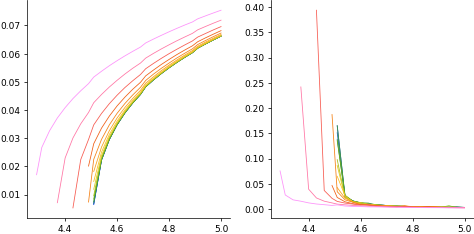

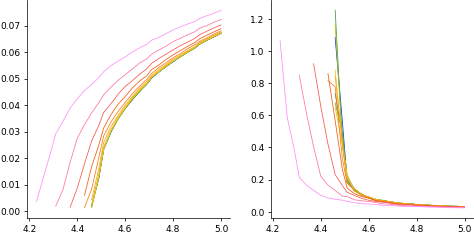

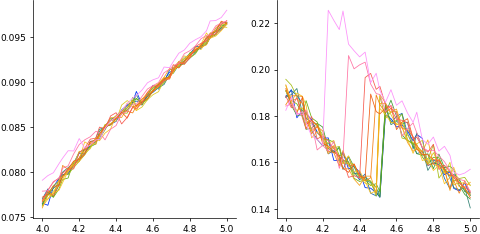

In [46]:
cm_string = "cet_CET_R1"
I_slope = np.sort(dfs_single.loc["snic"]["I_height"].unique())

cmap = cm.ScalarMappable(norm=colors.LogNorm(vmin=I_slope[0], vmax=I_slope[-1]), cmap=cm_string)
for sigma in dfs_single.loc["snic"].index.unique():
    bif = "snic"
    fig1, axes = plt.subplots(1,2,figsize=(8,4))
    curr_table = dfs_single.loc[bif].loc[sigma].copy()
    curr_table = curr_table[curr_table["n_waves"] > 10]

    pv_f = pd.pivot_table(curr_table, index=["I_mean"], columns=["I_height"], values="freq")
    axes[0].plot(pv_f.index, pv_f)
    for i,j in enumerate(axes[0].lines):
        j.set_color(cmap.to_rgba(pv_f.columns[i]))

    pv_cv = pd.pivot_table(curr_table, index=["I_mean"], columns=["I_height"], values="cv_isi")
    axes[1].plot(pv_f.index, pv_cv)
    for i,j in enumerate(axes[1].lines):
            j.set_color(cmap.to_rgba(pv_cv.columns[i]))

In [ ]:
for i in range(len(dfs_single.loc["snic"].index.unique())):
    fig1, axes = plt.subplots(2,2, figsize=(8,8))
    for j, bif in enumerate(bifs):
        ax, im, cbar = plot_heatmap(dfs_single.loc[bif].loc[0], "freq", axes[j,0],\
                            piv_index="I_mean", piv_column="I_height")
        ax, im, cbar = plot_heatmap(dfs_single.loc[bif].loc[0], "cv_isi", axes[j,1],\
                            piv_index="I_mean", piv_column="I_height")
        ax.set_title((bif, heights[i]))

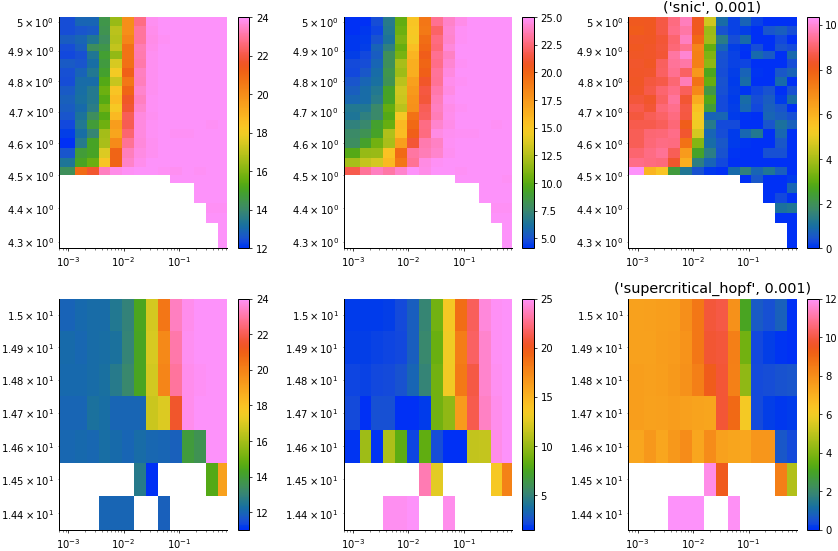

In [33]:
plt.close("all")
for i in range(len(dfs_single.loc["snic"].index.unique())):
    fig1, axes = plt.subplots(2,3, figsize=(12,8))
    for j, bif in enumerate(bifs):
        ax, im, cbar = plot_heatmap(dfs_single.loc[bif].loc[0], "mean_origin_pos", axes[j,0],\
                            piv_index="I_mean", piv_column="I_height")
        ax, im, cbar = plot_heatmap(dfs_single.loc[bif].loc[0], "mean_area", axes[j,1],\
                            piv_index="I_mean", piv_column="I_height")
        ax, im, cbar = plot_heatmap(dfs_single.loc[bif].loc[0], "std_origin_pos", axes[j,2],\
                            piv_index="I_mean", piv_column="I_height")
        ax.set_title((bif, heights[i]))
        plt.tight_layout()

In [ ]:
dfs_single.loc["supercritical_hopf"]

In [26]:
dfs_single.columns

Index(['D', 'sigma', 'I_mean', 'I_std', 'I_intercept', 'n_cells', 'duration',
       'sim_id', 'mean_origin_pos', 'frac_25', 'origin_entropy', 'mean_area',
       'frac_full_area', 'mean_isi', 'std_isi', 'cv_isi', 'phase_drift_rate',
       'phase_variance', 'crossings_per_cycle', 'freq'],
      dtype='object')

/tmp/ipykernel_113392/3785346821.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_expt = dfs_single.loc[i,0]
/tmp/ipykernel_113392/3785346821.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_expt = dfs_single.loc[i,0]


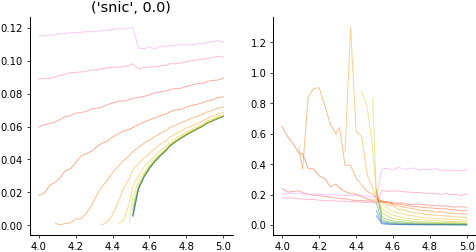

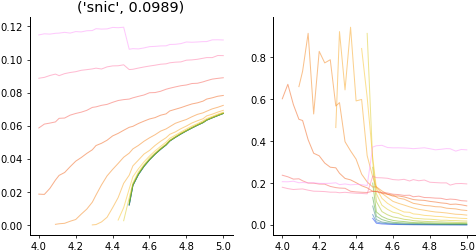

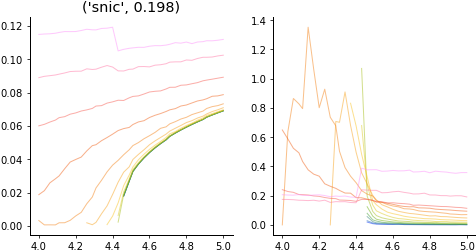

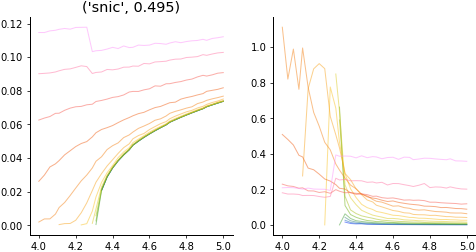

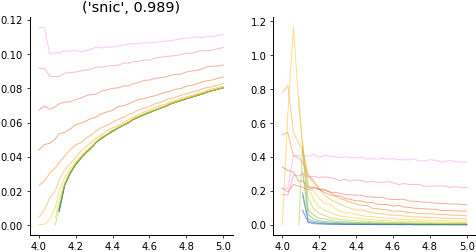

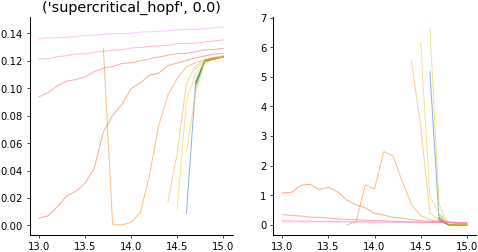

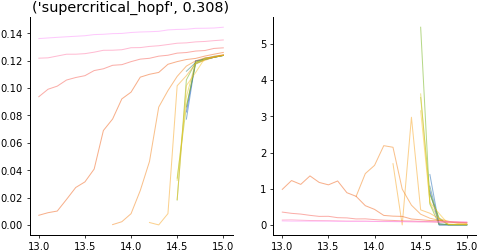

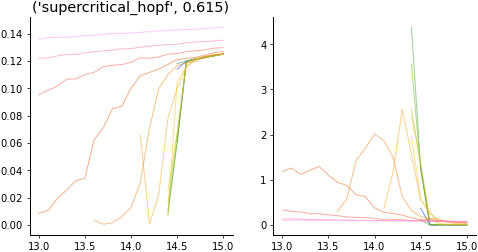

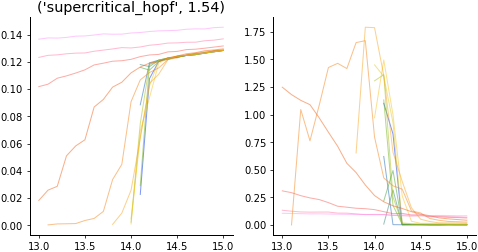

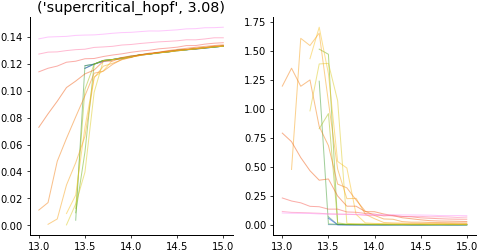

In [45]:
cm_string = "cet_CET_R1"
for i in dfs_single.index.unique("bifurcation"):
    df_expt = dfs_single.loc[i,0]
    for j in df_expt.index.unique():
        fig1, axes = plt.subplots(1,2, figsize=(8,4))
        f = pd.pivot_table(df_expt.loc[j], values="freq", index="sigma", columns=["I_mean"], dropna=False)
        covs = pd.pivot_table(df_expt.loc[j], values="cv_isi", index="sigma", columns=["I_mean"], dropna=False)
        sigmas = f.index.to_numpy()
        Is = f.columns.to_numpy()
        cmap = colormaps.ScalarMappable(norm=colors.LogNorm(vmin=sigmas[0], vmax=sigmas[-1]), cmap=cm_string)
        for row in range(len(sigmas)):
#             axes[0].scatter(Is, f.iloc[row,:], color=cmap.to_rgba(sigmas[row]),s=0.75,alpha=0.5)
#             axes[1].scatter(Is, covs.iloc[row,:], color=cmap.to_rgba(sigmas[row]),s=0.75,alpha=0.5)
            axes[0].plot(Is, f.iloc[row,:], color=cmap.to_rgba(sigmas[row]),alpha=0.5)
            axes[1].plot(Is, covs.iloc[row,:], color=cmap.to_rgba(sigmas[row]),alpha=0.5)
        axes[0].set_title((i,j))

Systematic sweep of I gradient

In [5]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20221027_pde_vary_height/"

In [11]:
dfs = {}

In [12]:
for i in range(len(subfolders)):
    dfs[bifs[i]] = process_stats(load_data(rootdir,subfolders[i]).sort_values(["D", "sigma", "I_height"]), subfolders[i])
    dfs[bifs[i]].reset_index().to_csv(os.path.join(rootdir, subfolders[i], "all_simulation_stats.csv"), index=False)

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20221027_pde_vary_height/supercritical_hopf/supercritical_hopf_20221028_171959_dbb359d3-a/params.pickle'
[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20221027_pde_vary_height/supercritical_hopf/supercritical_hopf_20221028_131347_65b79dc6-a/params.pickle'


In [13]:
dfs_single = pd.concat(dfs.values(), axis=0)
dfs_single.to_csv(os.path.join(figdir, "Figures", "Data", "pde_sims_gradI_sweep_height.csv"))

In [ ]:
dfs_single = pd.read_csv(os.path.join(figdir, "Figures", "Data", "pde_sims_gradI_sweep_height.csv"))

In [14]:
dfs_single["I_spatial_noise"] = [utils.round_rel_deviation(k.I_std/k.I_height, factor=10).item() for k in dfs_single.itertuples()]

In [87]:
np.unique(dfs_single["I_spatial_noise"])

array([0.  , 0.05, 0.1 ])

In [15]:
dfs_single = dfs_single.reset_index().set_index(["I_spatial_noise", "bifurcation"])

In [67]:
# for row in dfs_single.itertuples():
#     if row.Index[0]:
#         try:
#             shutil.move(os.path.join(rootdir, row.Index[1], row.sim_id), os.path.join(rootdir, "static_het_mistake", row.Index[1], row.sim_id))
#         except Exception as e:
#             raise e

/tmp/ipykernel_40254/3514776435.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax, im, cbar = plot_heatmap(dfs_single.loc[bif], "mean_origin_pos", axes[0],\
/tmp/ipykernel_40254/3514776435.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax, im, cbar = plot_heatmap(dfs_single.loc[bif], "std_origin_pos", axes[1],\
/tmp/ipykernel_40254/3514776435.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax, im, cbar = plot_heatmap(dfs_single.loc[bif], "mean_area", axes[2],\
/tmp/ipykernel_40254/3514776435.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax, im, cbar = plot_heatmap(dfs_single.loc[bif], "cv_isi", axes[3],\


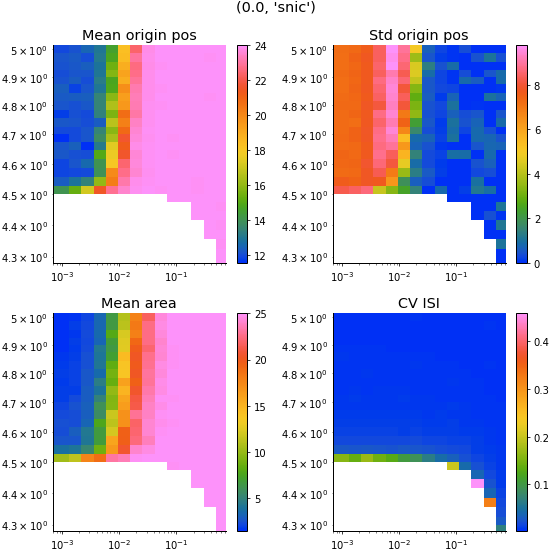

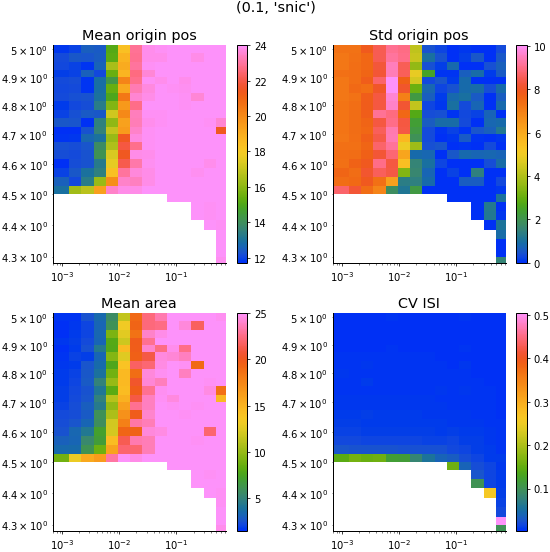

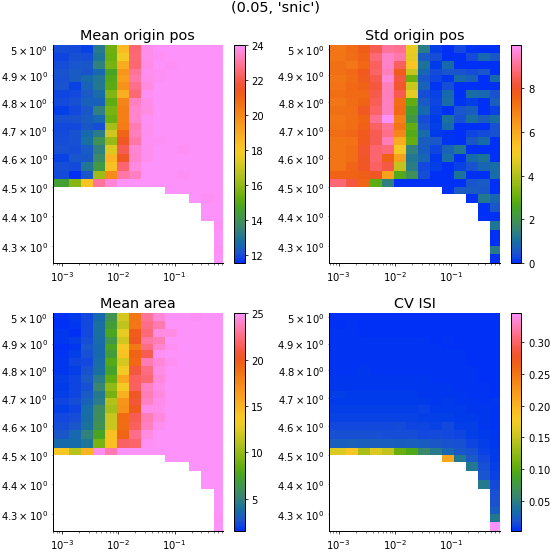

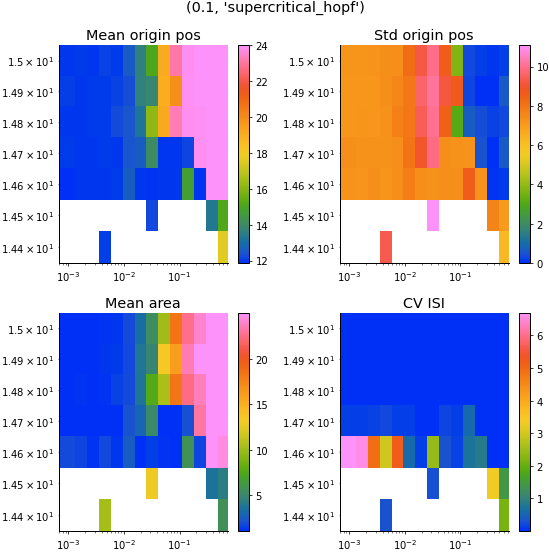

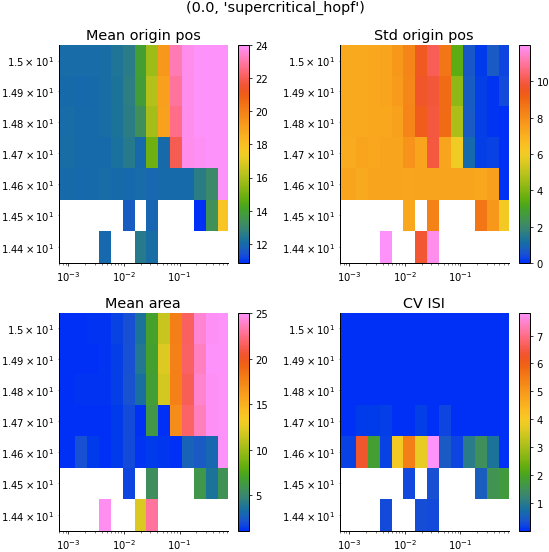

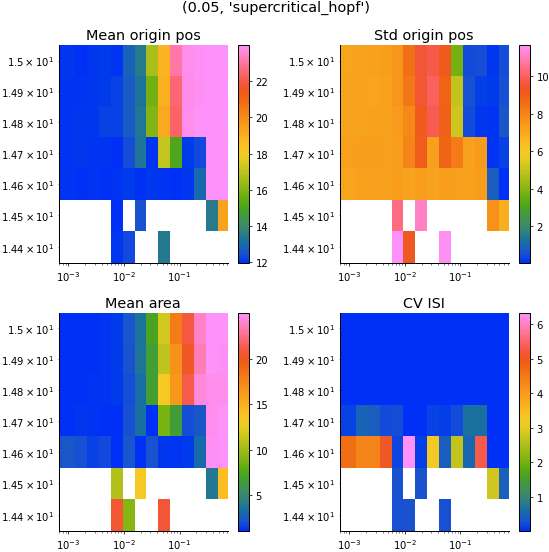

In [18]:
plt.close("all")
labels = ["Mean origin pos", "Std origin pos", "Mean area", "CV ISI"]
for bif in dfs_single.index.unique():
    fig1, axes = plt.subplots(2,2, figsize=(8,8))
    axes = axes.ravel()
    ax, im, cbar = plot_heatmap(dfs_single.loc[bif], "mean_origin_pos", axes[0],\
                            piv_index="I_mean", piv_column="I_height")
    ax, im, cbar = plot_heatmap(dfs_single.loc[bif], "std_origin_pos", axes[1],\
                            piv_index="I_mean", piv_column="I_height")
    ax, im, cbar = plot_heatmap(dfs_single.loc[bif], "mean_area", axes[2],\
                            piv_index="I_mean", piv_column="I_height")

    ax, im, cbar = plot_heatmap(dfs_single.loc[bif], "cv_isi", axes[3],\
                            piv_index="I_mean", piv_column="I_height")
    fig1.suptitle(bif)
    for j, ax in enumerate(axes):
        ax.set_title(labels[j])
    plt.tight_layout()

In [75]:
dfs_single.loc[1]

,D,sigma,I_mean,I_std,I_height,I_intercept,n_cells,duration,sim_id,mean_origin_pos,...,origin_entropy,mean_area,frac_full_area,mean_isi,std_isi,cv_isi,phase_drift_rate,phase_variance,crossings_per_cycle,freq
bifurcation,,,,,,,,,,,,,,,,,,,,,
snic,0.5,0.03,4.97,0.00005,0.001,12,25,10000.0,snic_20221028_154113_3b2fdbbf-5,11.862786,...,4.639576,1.554320,0.000096,15.417461,0.053901,0.003496,7.849310e-07,0.028201,6.259720,0.064862
snic,0.5,0.03,5.00,0.00005,0.001,12,25,10000.0,snic_20221028_154114_ba7bd5a0-f,12.016346,...,4.639332,1.537104,0.000186,15.102435,0.049754,0.003294,8.869580e-07,0.024931,6.121951,0.066214
snic,0.5,0.03,4.91,0.00005,0.001,12,25,10000.0,snic_20221028_154043_bb78bcc7-e,12.094900,...,4.637993,1.718404,0.000665,16.143857,0.061893,0.003834,2.016536e-06,0.044013,5.845024,0.061943
snic,0.5,0.03,4.86,0.00005,0.001,12,25,10000.0,snic_20221028_154041_3d3c9ef4-f,12.083040,...,4.639318,1.664776,0.000227,17.039671,0.075043,0.004404,5.679698e-06,0.043810,6.242685,0.058687
snic,0.5,0.03,4.57,0.00005,0.001,12,25,10000.0,snic_20221028_154033_06b0a5c2-c,12.006454,...,4.608562,2.799924,0.018223,33.874279,0.560522,0.016547,8.765785e-06,0.190115,5.536585,0.029521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
supercritical_hopf,0.5,0.03,14.60,0.03050,0.611,12,25,10000.0,supercritical_hopf_20221028_160003_eba1ca7d-7,23.999169,...,0.009705,24.999169,0.999169,8.312967,0.017810,0.002142,1.225015e-07,1.519737,0.000000,0.120294
supercritical_hopf,0.5,0.03,14.70,0.03050,0.611,12,25,10000.0,supercritical_hopf_20221028_155911_ff9cc29c-0,23.990107,...,0.027251,24.950536,0.995878,8.259965,0.015374,0.001861,2.468832e-07,1.316069,0.000000,0.121066
supercritical_hopf,0.5,0.03,14.80,0.03050,0.611,12,25,10000.0,supercritical_hopf_20221028_160031_82c2194c-a,23.967897,...,0.118396,24.638042,0.970305,8.144995,0.020794,0.002554,3.113554e-07,1.031532,0.000000,0.122775
